<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ufidon/ml/blob/main/mod6/dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ufidon/ml/blob/main/mod6/dnn.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br>

Training Deep Neural Networks
---
_homl3 ch11_

- A DNN has 10 and more layers
- each layer contains hundreds of neurons linked by hundreds of thousands of connections
- i.e. there are hundreds of thousands even millions of parameters


Problems in training DNNs
---
- gradients growing ever smaller or larger during backpropagating the DNN
  - called the `vanishing and exploding gradients` problems
  - both make lower layers very hard to train
- `insufficient data` for such a large DNN,
  - or it might be too costly to label, e.x. 
  - can be tackled with `transfer learning and unsupervised pretraining`
- A model with millions of parameters would severely risk `overfitting` the training set
  - especially if there are not enough training instances 
  - or if they are too noisy
  - can be tackled with `regularization techniques`
- Training may be extremely `slow`
  - can be tackled with various `optimizers` that can speed up training large models tremendously

In [31]:
import sys
if "google.colab" in sys.modules:
  %pip install -q -U keras-tuner

In [32]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sklearn as skl, sklearn.datasets as skds

import tensorflow as tf, keras_tuner as kt

# The Vanishing and Exploding Gradients Problems
- the backprop backward step propagates the error gradient from the output layer to the input layer
  - computes the gradient of the cost function with regard to each parameter in the network
  - then uses these gradients to update each parameter with a gradient descent step
- Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers
  - As a result, the gradient descent update leaves the lower layers’ connection weights virtually unchanged
  - and training never converges to a good solution
  - This is called the `vanishing gradients problem`
- In some cases, the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges
  - This is the `exploding gradients problem`
  - often happens in recurrent neural networks
- More generally, DNNs suffer from `unstable gradients`
  - different layers may learn at widely different speeds

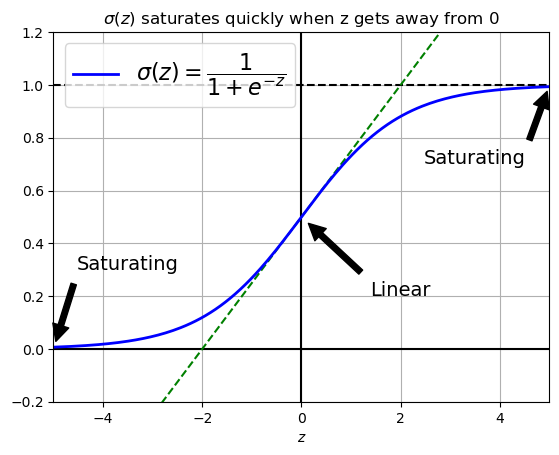

In [33]:
# 1. the sigmoid (logistic) activation function saturates quickly
#    when z gets away from 0 
#    i.e. the derivative gets very small

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

fig1, ax1 = plt.subplots()
ax1.plot([-5, 5], [0, 0], 'k-')
ax1.plot([-5, 5], [1, 1], 'k--')
ax1.plot([0, 0], [-0.2, 1.2], 'k-')
ax1.plot([-5, 5], [-3/4, 7/4], 'g--')
ax1.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
ax1.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
ax1.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
ax1.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
ax1.grid(True)
ax1.axis([-5, 5, -0.2, 1.2])
ax1.set_xlabel("$z$")
ax1.legend(loc="upper left", fontsize=16);
ax1.set_title(r"$\sigma(z)$" " saturates quickly when z gets away from 0");

Suspect caused the vanishing gradient problem
---
- the combination of sigmoid activation function and weight initialization technique ℕ(0,1)
  - causes the variance keeps increasing after each layer 
  - until the activation function saturates at the top layers
- this saturation is made worse due that 
  - the sigmoid function has a mean of 0.5, not 0
  - the hyperbolic tangent function has a mean of 0 
    - so it behaves slightly better than the sigmoid function
- ∴ there is almost no gradient to propagate back through the network
  - what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers
  - so there is really nothing left for the lower layers

Glorot or Xavier Initialization 
---
when using the `sigmoid` activation function, `Glorot initialization` significantly 
- alleviates the unstable gradients problem
  - speeds up training considerably 
  - becomes one of the practices that led to the success of deep learning
- initializes the weights of each layer randomly with
  - normal distribution: ${\displaystyle N(0,σ^2)}$ where  ${\displaystyle σ^2=\frac{1}{\operatorname{fan}_{avg}}}$, or
  - uniform distribution: ${\displaystyle {\displaystyle {\mathcal {U}}_{[-r,r]}}}$ where ${\displaystyle r=\sqrt{\dfrac{3}{\operatorname{fan}_{avg}}} = \sqrt{3}\sigma }$
  - ${\displaystyle \operatorname{fan}_{avg} = \dfrac{ \operatorname{fan}_{in}} {\operatorname{fan}_{out}}}$
  - the numbers of inputs and outputs of a layer are called the `fan-in` and `fan-out` of the layer
- `LeCun initialization` replaces $fan_{avg}$ with $fan_{in}$
  - equivalent to Glorot initialization when $fan_{in} = fan_{out}$

He Initialization 
---
- similar strategies have been proposed for different activation functions
  - they differ only by the scale of the variance and whether they use $fan_{avg}$ or $fan_{in}$
- The initialization strategy proposed for the `ReLU` activation function and its variants is called `He initialization` or `Kaiming initialization`
- Initialization parameters for each type of activation function

| Initialization |  Activation functions | σ² (Normal) |
|:--:|:--:|:--:|
| Glorot |  None, tanh, sigmoid, softmax |  $1 / fan_{avg}$ |
| He | ReLU, Leaky ReLU, ELU, GELU, Swish, Mish | $2 / fan_{in}$ |
| LeCun |  SELU | $1 / fan_{in}$ |


In [34]:
# 1. Glorot and He Initialization
# 1) Keras uses `Glorot` initialization with a uniform distribution by default
#    you can switch to `He` initialization by setting
#    kernel_initializer=​ "he_uniform" or "he_normal"

dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

# 2) you can obtain any of the initializations in the table above and more
#    using the `VarianceScaling` initializer
# e.g. use He initialization with a uniform distribution and 
# based on fanavg (rather than fanin)

he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

Better Activation Functions
---
- `ReLU` 
  - does not saturate for positive values and it is very fast to compute
  - but it suffers the problem of `dying ReLUs` because it saturates when z is negative
    - when the weighted sum of a neuron’s inputs plus its bias term is negative for all instances in the training set, the neuron outputs 0 only
    - i.e. the gradient descent stops working because the gradient of the ReLU function is zero when its input is negative
  - this problem can be solved with `Leaky ReLU'
- `Leaky ReLU`
  - defined as $LeakyReLU_\alpha(z)$ = max(αz, z)
  - The hyperparameter α defines how much the function “leaks”: 
    - it is the slope of the function for z < 0
  - `randomized leaky ReLU (RReLU)` is where 
    - α is picked randomly in a given range during training 
    - and is fixed to an average value during testing
  - `parametric leaky ReLU (PReLU)` is where
    - α is a parameter that can be tuned by backprop like any other parameter
- ReLU, leaky ReLU, and PReLU are all `not smooth` function
  - their derivatives abruptly change at z = 0
  - this sort of discontinuity can make gradient descent bounce around the optimum, 
  - and slow down convergence


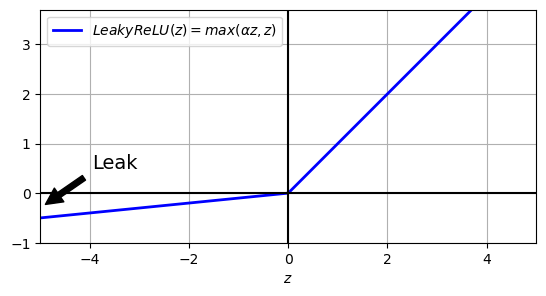

In [35]:
# 1. LeakyReLU

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
fig2, ax2 = plt.subplots()
ax2.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
ax2.plot([-5, 5], [0, 0], 'k-')
ax2.plot([0, 0], [-1, 3.7], 'k-')
ax2.grid(True)
props = dict(facecolor='black', shrink=0.1)
ax2.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
ax2.set_xlabel("$z$")
ax2.axis([-5, 5, -1, 3.7])
ax2.set_aspect("equal")
ax2.legend();

In [36]:
# 2. Keras includes the classes `LeakyReLU` and `PReLU`
#    they should be used with He initialization

leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # default alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [37]:
# 2.1 LeakyReLU can be used as a separate layer
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

ELU and SELU
---
- two `smooth` variants of the ReLU
- `exponential linear unit (ELU)`
  - ${\displaystyle ELU_{\alpha}(z) =  {\begin{cases}\alpha \left(e^{z}-1\right)&{\text{if }}z< 0\\z&{\text{if }}z \ge 0\end{cases}}}$
  - If α = 1 then ELU is smooth everywhere
- `scaled ELU (SELU)`
  - ${\displaystyle SELU_{\lambda, \alpha}(z)\lambda {\begin{cases}\alpha (e^{z}-1)&{\text{if }}z<0\\z&{\text{if }}z\geq 0\end{cases}}}$
  - λ=1.0507 and α=1.67326
  - if SELU is used in all hidden layers of an NN with only dense layers
  - then the NN will self-normalize: 
    - the output of each layer will tend to preserve a mean of 0 and a standard deviation of 1 during training, 
    - which solves the vanishing/exploding gradients problem
  - self-normalization needs further conditions below:
    - The input features must be standardized: mean 0 and standard deviation 1
    - Every hidden layer’s weights must be initialized using LeCun normal initialization
    - The self-normalizing property is only guaranteed with plain MLPs
    - You cannot use regularization techniques like $\ell_1$ or $\ell_2$ regularization, max-norm, batch-norm, or regular dropout

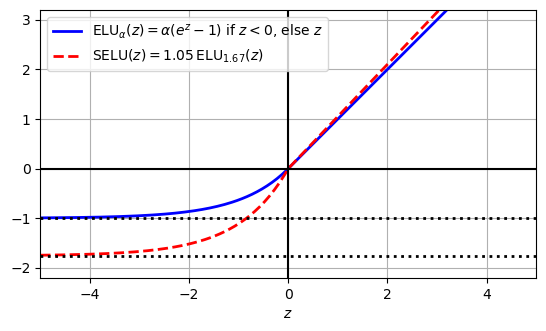

In [38]:
# 1. ELU and SELU

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
fig3, ax3 = plt.subplots()
ax3.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
ax3.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
ax3.plot([-5, 5], [0, 0], 'k-')
ax3.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
ax3.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
ax3.plot([0, 0], [-2.2, 3.2], 'k-')
ax3.grid(True)
ax3.axis([-5, 5, -2.2, 3.2])
ax3.set_xlabel("$z$")
ax3.set_aspect("equal")
ax3.legend();

In [39]:
# 2. apply ELU and SELU
elu_dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

selu_dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

In [40]:
# 3. SELU nn can regularize itself
# 1) create a nn for Fashion MNIST with 100 hidden layers, 
#    using the SELU activation function

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [41]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [42]:
# 2) load and normalize the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [43]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [44]:
# 3) scale the inputs to mean 0 and standard deviation 1 before training the nn
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [45]:
# 4) The network managed to learn, despite it is 100 layers deep
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5


1719/1719 [==============================] - 20s 10ms/step - loss: 1.6675 - accuracy: 0.3654 - val_loss: 1.1900 - val_accuracy: 0.5214
Epoch 2/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.9249 - accuracy: 0.6320 - val_loss: 0.7427 - val_accuracy: 0.7254
Epoch 3/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.7326 - accuracy: 0.7303 - val_loss: 0.6413 - val_accuracy: 0.7644
Epoch 4/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.6331 - accuracy: 0.7667 - val_loss: 0.6678 - val_accuracy: 0.7628
Epoch 5/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.6179 - accuracy: 0.7743 - val_loss: 0.6344 - val_accuracy: 0.7610


In [46]:
# 4) however, same nn with RELU suffers from the vanishing/exploding gradients problem
#   its performance is much worse

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [47]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [48]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))


Epoch 1/5
1719/1719 [==============================] - 17s 9ms/step - loss: 1.9516 - accuracy: 0.2359 - val_loss: 1.3482 - val_accuracy: 0.4196
Epoch 2/5
1719/1719 [==============================] - 15s 9ms/step - loss: 1.2940 - accuracy: 0.4381 - val_loss: 1.2244 - val_accuracy: 0.4390
Epoch 3/5
1719/1719 [==============================] - 15s 9ms/step - loss: 1.0951 - accuracy: 0.5224 - val_loss: 0.8922 - val_accuracy: 0.6112
Epoch 4/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.8725 - accuracy: 0.6192 - val_loss: 0.8453 - val_accuracy: 0.6480
Epoch 5/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.7824 - accuracy: 0.6820 - val_loss: 0.7268 - val_accuracy: 0.7328


GELU, Swish, and Mish
---
- smooth, nonconvex, and nonmonotonic variants of ReLU
- `Gaussian Error Linear Unit (GELU)`
  - ${\displaystyle \operatorname {GELU}(z)=z\Phi(z) \approx z\sigma (1.702z) }$
  - Φ is the standard Gaussian cumulative distribution function
    - ${\displaystyle \Phi (z)={\frac {1}{\sqrt {2\pi }}}\int _{-\infty }^{z}e^{-t^{2}/2}\,dt}$
- `Swish`
  - ${\displaystyle \operatorname {swish}_{\beta} (z)=z\sigma (\beta z)={\frac {z}{1+e^{-\beta z}}}}$
  - β is like any other hyperparameter which can be tuned and trained
  - β=1, `zσ(z)` is called `sigmoid linear unit (SiLU)`
- `Mish`
  - similar to `Swish`, defined as
  - ${\displaystyle \operatorname {mish}(z) = z\tanh (\operatorname{softplus(z)}) = z\tanh (\log(1+e^z)) }$
- they all outperform ReLU but at the cost of more computing resources
- ReLU remains a good default for simple tasks
  - Swish and Mish are better default for more complex tasks

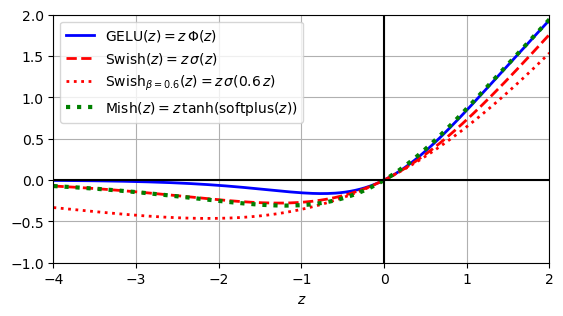

In [49]:
# 1. GELU, Swish, SiLU and Mish
def swish(z, beta=1):
    return z * tf.math.sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6

fig4, ax4 = plt.subplots()
ax4.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
ax4.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
ax4.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
ax4.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
ax4.plot([-4, 2], [0, 0], 'k-')
ax4.plot([0, 0], [-2.2, 3.2], 'k-')
ax4.grid(True)
ax4.axis([-4, 2, -1, 2])
ax4.set_aspect("equal")
ax4.set_xlabel("$z$")
ax4.legend(loc="upper left");

Batch Normalization (BN)
---
- a different way to solve the unstable gradients problem
- simply zero-centers and normalizes each input
  - then scales and shifts the result using two new parameter vectors per layer
    - one for scaling, the other for shifting
- no need to standardize the training set if a BN layer is added to the first layer of a NN
  - no need for StandardScaler or Normalization
  - the BN layer will do the task
- the BN algorithm on a mini-batch B of size m of the entire training set:
  - ${\displaystyle \boldsymbol{\mu} _{B}={\frac {1}{m}}\sum _{i=1}^{m}\mathbf{x}_{i}}$
    - the vector of input means
  - ${\displaystyle \boldsymbol{\sigma} _{B}^{2}={\frac {1}{m}}\sum _{i=1}^{m}(\mathbf{x}_{i}-\boldsymbol{\mu} _{B})^{2}}$
    - the vector of input standard deviations
  - ${\displaystyle {\hat{\mathbf{x}}_{i}^{(k)}={\frac {\mathbf{x}_{i}^{(k)}-\boldsymbol{\mu} _{B}^{(k)}}{\sqrt {\left(\boldsymbol{\sigma} _{B}^{(k)}\right)^{2}+\epsilon }}}}}$
    - the vector of zero-centered and normalized inputs
    - ε is the smoothing term, a tiny number that avoids division by zero and ensures the 
gradients don’t grow too large
  - ${\displaystyle \mathbf{z}_{i}^{(k)}=\boldsymbol{\gamma} ^{(k)} \otimes {\hat {\mathbf{x}}}_{i}^{(k)}+\boldsymbol{\beta} ^{(k)}}$
    - the output of the BN operation
    - γ is the output `scale` parameter vector for the layer
    - ⊗ represents element-wise multiplication
    - β is the output shift (`offset`) parameter vector for the layer

BN benefits, limits and fusion
---
- BN standardizes its inputs, then rescales and offsets them during training
- but it is complex during test since it predicts for individual instances rather than for batches of instances, two ways to solve this problem
  - `method 1`: at the end of training, run the whole training set through the nn and compute the mean and standard deviation of each input of the BN layer
  - use these final input means and standard deviations for predictions
  - `method 2`: estimate these final statistics during training by using a `moving average` of the layer’s input means and standard deviations
    - this is the default method for Keras `BatchNormalization` layer
- BN strongly reduced the vanishing gradients problem to the point that
  -  saturating activation functions such as `tanh` and `sigmoid` can be used
  -  the nn also becomes less sensitive to the weight initialization
  -  much larger learning rates are used to significantly speed up the learning process
- BN also acts like a regularizer reducing the need for other regularization techniques such as `dropout`
- but there is a runtime penalty: the nn makes slower predictions due to the extra computations required at each layer
  - this can be solved by `fusing` layer BNᵢ into its previous layer Lᵢ:
    - if Lᵢ computes $\mathbf{XW + b}$, 
    - then BNᵢ computes  $\mathbf{\boldsymbol{γ} ⊗ (XW + b – \boldsymbol{μ}) / \boldsymbol{σ} + \boldsymbol{β}}$
      - the smoothing term ε in the denominator is ignored
    - the fusion is replacing Lᵢ’s weights $\mathbf{W}$ and biases $\mathbf{b}$ by
      - $\mathbf{W′ = \boldsymbol{γ}⊗W / \boldsymbol{σ}}$ and $\mathbf{b′ = \boldsymbol{γ} ⊗ (b – \boldsymbol{μ}) / \boldsymbol{σ} + \boldsymbol{β}}$
      - ∴ the equation simplifies to $\mathbf{XW′ + b′}$

In [50]:
# 1. Apply batch normalization with Keras by
#  adding a BatchNormalization layer before or after each hidden layer’s activation function

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [51]:
# 1) each BN layer adds four parameters per input: γ, β, μ, and σ 
# e.g. BN1 adds 3,136 = 4*784 parameters
#  μ and σ, are the moving averages; they are not affected by backpropagation, 
#  so Keras calls them “non-trainable”
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [52]:
# trainable parameters in BN1
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [53]:
# 2) show the model works
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2


1719/1719 [==============================] - 4s 2ms/step - loss: 0.5590 - accuracy: 0.8067 - val_loss: 0.4027 - val_accuracy: 0.8556
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4058 - accuracy: 0.8567 - val_loss: 0.3683 - val_accuracy: 0.8672


In [54]:
# 3) Sometimes applying BN before the activation function works better
# Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, 
# since the `BatchNormalization` layer includes one offset parameter per input, 
# so you can remove the bias term from the previous layer by setting 
#  `use_bias=False` :

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [55]:
# 4) this model works as well
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6140 - accuracy: 0.7936 - val_loss: 0.4293 - val_accuracy: 0.8438
Epoch 2/2
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4268 - accuracy: 0.8509 - val_loss: 0.4199 - val_accuracy: 0.8404


BN hyperparameter: momentum and axis
---
- `momentum` m is used to update the exponential moving averages $\hat{\mathbf{v}}$:
  - $\hat{\mathbf{v}} = \hat{\mathbf{v}}m + \mathbf{v}(1-m)$
  - given a new value $\mathbf{v}$ of input means or standard deviations computed over the current batch
  - m is  is typically close to 1 such as 0.9, 0.99, 0.999, etc.
    - more 9s for larger datasets and for smaller mini-batches
- `axis` determines which axis should be normalized
  -  defaults to –1, meaning that by default it will normalize the last axis
  -  e.g.  given batch shape [batch size, features], 
     -  each input feature will be normalized based on the mean and standard deviation computed across all the instances in the batch
- BN has become one of the most-used layers in DNNs
  - especially deep convolutional neural networks (CNN)

Gradient Clipping
---
- Another technique to mitigate the `exploding gradients problem`
- clips the gradients during backpropagation so that they never exceed some threshold
- generally used in recurrent neural networks (RNN)
- two types in Keras:
  - `clipvalue` may change the direction of the gradient vector
    - it clips all the partial derivatives of the loss to be between `-clipvalue` and `clipvalue`
  - `clipnorm` does not change the direction of the gradient vector
    - it clips the whole gradient if its $\ell_2$ norm is greater than `clipnorm`
    - but it may clip very small partial gradients

In [56]:
# 1. All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:
optimizer_cv = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_cv)

optimizer_cn = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_cn)

# Reusing Pretrained Layers
- `transfer learning` reuses most of an existent E model's layers to solve similar problems
  - speeds up training considerably
  - requires significantly less training data
- the lower layers of E, the more reusable, the upper the less
  - the output layer of E should usually be replaced
  - freeze all layers other than the output layer
    - then unfreeze the hidden layers from top to bottom one by one
    - train the model after each unfreezing to see how it performs
    - small learning rate is preferred to avoid wrecking old fine-tuned weights
    - top hidden layers could also be dropped even replaced
    - fresh new top hidden layers could be added
  - until the new model's performance is satisfied
 

In [57]:
# 1. transfer learning transfer the capabilities of model A to B
# in classifying the fashion MNIST
# - model A tackles the task of predicting 8 fashions except for 
#     T-shirts/tops and pullovers (classes 0 and 2)
# - model B tackles the task of predicting the 2 fashions model A missed
#     with a much smaller training set

# 1) create datasets from A and B
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)

X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]


# 2) build, train and save model A
model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 2s 1ms/step - loss: 1.0828 - accuracy: 0.6424 - val_loss: 0.6929 - val_accuracy: 0.7789
Epoch 2/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.6018 - accuracy: 0.8099 - val_loss: 0.5155 - val_accuracy: 0.8308
Epoch 3/20
1376/1376 [==============================] - 1s 1ms/step - loss: 0.4827 - accuracy: 0.8463 - val_loss: 0.4395 - val_accuracy: 0.8533
Epoch 4/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.4226 - accuracy: 0.8625 - val_loss: 0.3928 - val_accuracy: 0.8659
Epoch 5/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.3858 - accuracy: 0.8717 - val_loss: 0.3799 - val_accuracy: 0.8684
Epoch 6/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.3607 - accuracy: 0.8786 - val_loss: 0.3509 - val_accuracy: 0.8787
Epoch 7/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.3427 - accuracy: 0.8832 - val_loss: 0.3436 - val_accuracy:

In [58]:
# 3) train and evaluate model B, without reusing model A

model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6939 - accuracy: 0.4900 - val_loss: 0.6718 - val_accuracy: 0.5173
Epoch 2/20
7/7 [==============================] - 0s 7ms/step - loss: 0.6709 - accuracy: 0.5500 - val_loss: 0.6527 - val_accuracy: 0.6034
Epoch 3/20
7/7 [==============================] - 0s 7ms/step - loss: 0.6489 - accuracy: 0.6250 - val_loss: 0.6355 - val_accuracy: 0.7221
Epoch 4/20
7/7 [==============================] - 0s 7ms/step - loss: 0.6291 - accuracy: 0.7650 - val_loss: 0.6207 - val_accuracy: 0.7854
Epoch 5/20
7/7 [==============================] - 0s 12ms/step - loss: 0.6122 - accuracy: 0.8350 - val_loss: 0.6070 - val_accuracy: 0.8299
Epoch 6/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5966 - accuracy: 0.8650 - val_loss: 0.5935 - val_accuracy: 0.8595
Epoch 7/20
7/7 [==============================] - 0s 7ms/step - loss: 0.5807 - accuracy: 0.8850 - val_loss: 0.5807 - val_accuracy: 0.8714
Epoch 8/20
7/7 [================

[0.4550462067127228, 0.9070000052452087]

In [59]:
# 4) reuse the pretrained model A
model_A = tf.keras.models.load_model("my_model_A")

# reuse all layers except the output layer
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1]) 
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# freeze all reused layers
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [60]:
# 5) train the reused model
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 19ms/step - loss: 3.3243 - accuracy: 0.4500 - val_loss: 2.2634 - val_accuracy: 0.4847
Epoch 2/4
7/7 [==============================] - 0s 7ms/step - loss: 1.8895 - accuracy: 0.4500 - val_loss: 1.2007 - val_accuracy: 0.4837
Epoch 3/4
7/7 [==============================] - 0s 9ms/step - loss: 0.9276 - accuracy: 0.4500 - val_loss: 0.6254 - val_accuracy: 0.5410
Epoch 4/4
7/7 [==============================] - 0s 9ms/step - loss: 0.5613 - accuracy: 0.6550 - val_loss: 0.5514 - val_accuracy: 0.7636
Epoch 1/16
7/7 [==============================] - 0s 18ms/step - loss: 0.5093 - accuracy: 0.8150 - val_loss: 0.5083 - val_accuracy: 0.8259
Epoch 2/16
7/7 [==============================] - 0s 7ms/step - loss: 0.4642 - accuracy: 0.9000 - val_loss: 0.4760 - val_accuracy: 0.8556
Epoch 3/16
7/7 [==============================] - 0s 7ms/step - loss: 0.4339 - accuracy: 0.9200 - val_loss: 0.4505 - val_accuracy: 0.8665
Epoch 4/16
7/7 [====================

In [61]:
# 6) evaluate the reused model

model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 997us/step - loss: 0.2957 - accuracy: 0.9245


[0.29568415880203247, 0.9244999885559082]

In [62]:
# the performance is a little bit better than the fresh new model B above
# from 0.929 to 0.9355
# the error rate dropped by 9%
1 - (100 - 93.55)/(100 - 92.9)

0.09154929577464677

In [3]:
!rm -rf ./my_model_A/

Unsupervised Pretraining
---
- tackles situation S without sufficient labeled training data nor similar models
- `method 1`: trains an unsupervised model such as an autoencoder or a generative adversarial network (GAN)
  - replaced the early-day unsupervised pretraining technique which
    - trains one layer a time with restricted Boltzmann machines (RBMs)
  - then reuse the lower layers of the autoencoder or the lower layers of the GAN’s discriminator
  - add some hidden layers and an output layer on top to tackle S with supervised learning
- `method 2`: pretrains on an auxiliary task for which labeled training data can be easily obtained or generated
  -  then reuse the lower layers of the auxiliary network for the actual task

# Faster Optimizers
The following popular optimization algorithms can speed up DNN training:
- momentum
- Nesterov accelerated gradient
- AdaGrad
- RMSProp
- Adam and its variants

In [63]:
# 1. a small function to test optimizers on Fashion MNIST

def build_model():
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [74]:
# 0) sgd
optimizer0 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0)
history_sgd = build_and_train_model(optimizer0) 

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 1.4110 - accuracy: 0.5815 - val_loss: 0.8985 - val_accuracy: 0.7034
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7974 - accuracy: 0.7275 - val_loss: 0.7009 - val_accuracy: 0.7590
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6730 - accuracy: 0.7752 - val_loss: 0.6160 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6060 - accuracy: 0.7977 - val_loss: 0.5668 - val_accuracy: 0.8080
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5634 - accuracy: 0.8109 - val_loss: 0.5315 - val_accuracy: 0.8190
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5338 - accuracy: 0.8196 - val_loss: 0.5099 - val_accuracy: 0.8212
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5122 - accuracy: 0.8260 - val_loss: 0.5008 - val_accuracy:

In [73]:
# 1). momentum
optimizer1 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
history_momentum = build_and_train_model(optimizer1)

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6937 - accuracy: 0.7665 - val_loss: 0.4823 - val_accuracy: 0.8380
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4584 - accuracy: 0.8373 - val_loss: 0.4168 - val_accuracy: 0.8516
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4154 - accuracy: 0.8535 - val_loss: 0.3960 - val_accuracy: 0.8568
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3888 - accuracy: 0.8609 - val_loss: 0.3782 - val_accuracy: 0.8640
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3680 - accuracy: 0.8689 - val_loss: 0.3921 - val_accuracy: 0.8638
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3538 - accuracy: 0.8726 - val_loss: 0.3616 - val_accuracy: 0.8684
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3428 - accuracy: 0.8763 - val_loss: 0.3623 - val_accuracy:

In [65]:
# 2). Nesterov accelerated gradient
optimizer2 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)
history_nesterov = build_and_train_model(optimizer2) 

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6926 - accuracy: 0.7626 - val_loss: 0.4961 - val_accuracy: 0.8262
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4598 - accuracy: 0.8400 - val_loss: 0.4202 - val_accuracy: 0.8492
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4175 - accuracy: 0.8536 - val_loss: 0.4043 - val_accuracy: 0.8640
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3908 - accuracy: 0.8614 - val_loss: 0.4048 - val_accuracy: 0.8518
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3683 - accuracy: 0.8685 - val_loss: 0.3665 - val_accuracy: 0.8670
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3543 - accuracy: 0.8741 - val_loss: 0.3766 - val_accuracy: 0.8630
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3403 - accuracy: 0.8780 - val_loss: 0.3668 - val_accuracy:

In [66]:
# 3). AdaGrad
optimizer3 = tf.keras.optimizers.Adagrad(learning_rate=0.001)
history_adagrad = build_and_train_model(optimizer)  

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 1.3496 - accuracy: 0.5781 - val_loss: 0.8720 - val_accuracy: 0.7212
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7790 - accuracy: 0.7381 - val_loss: 0.6883 - val_accuracy: 0.7628
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6594 - accuracy: 0.7763 - val_loss: 0.6114 - val_accuracy: 0.7868
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5958 - accuracy: 0.7977 - val_loss: 0.5609 - val_accuracy: 0.8054
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5547 - accuracy: 0.8119 - val_loss: 0.5313 - val_accuracy: 0.8154
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5265 - accuracy: 0.8208 - val_loss: 0.5094 - val_accuracy: 0.8224
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5060 - accuracy: 0.8273 - val_loss: 0.4942 - val_accuracy:

In [67]:
# 4). RMSProp
optimizer4 = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
history_rmsprop = build_and_train_model(optimizer4) 

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5161 - accuracy: 0.8132 - val_loss: 0.4482 - val_accuracy: 0.8418
Epoch 2/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3962 - accuracy: 0.8576 - val_loss: 0.4130 - val_accuracy: 0.8562
Epoch 3/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3742 - accuracy: 0.8674 - val_loss: 0.3990 - val_accuracy: 0.8608
Epoch 4/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3646 - accuracy: 0.8732 - val_loss: 0.4741 - val_accuracy: 0.8592
Epoch 5/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3619 - accuracy: 0.8759 - val_loss: 0.4159 - val_accuracy: 0.8756
Epoch 6/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3611 - accuracy: 0.8761 - val_loss: 0.4702 - val_accuracy: 0.8338
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3582 - accuracy: 0.8776 - val_loss: 0.4500 - val_accuracy:

In [68]:
# 5) Adam
optimizer5 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)
history_adam = build_and_train_model(optimizer5) 

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4992 - accuracy: 0.8210 - val_loss: 0.4201 - val_accuracy: 0.8418
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3726 - accuracy: 0.8640 - val_loss: 0.3555 - val_accuracy: 0.8710
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3402 - accuracy: 0.8755 - val_loss: 0.3536 - val_accuracy: 0.8714
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3178 - accuracy: 0.8826 - val_loss: 0.3679 - val_accuracy: 0.8672
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2981 - accuracy: 0.8896 - val_loss: 0.3681 - val_accuracy: 0.8674
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2857 - accuracy: 0.8933 - val_loss: 0.3209 - val_accuracy: 0.8876
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2729 - accuracy: 0.8980 - val_loss: 0.3441 - val_accuracy:

In [69]:
# 6) Adamax
optimizer6 = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)
history_adamax = build_and_train_model(optimizer6)

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5353 - accuracy: 0.8126 - val_loss: 0.4177 - val_accuracy: 0.8520
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3994 - accuracy: 0.8576 - val_loss: 0.3683 - val_accuracy: 0.8652
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3594 - accuracy: 0.8700 - val_loss: 0.3444 - val_accuracy: 0.8752
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3340 - accuracy: 0.8793 - val_loss: 0.3559 - val_accuracy: 0.8672
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3161 - accuracy: 0.8857 - val_loss: 0.3384 - val_accuracy: 0.8734
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2996 - accuracy: 0.8903 - val_loss: 0.3424 - val_accuracy: 0.8714
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2870 - accuracy: 0.8958 - val_loss: 0.3193 - val_accuracy:

In [70]:
# 7) Nadam
optimizer7 = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)
history_nadam = build_and_train_model(optimizer7) 

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4875 - accuracy: 0.8253 - val_loss: 0.3929 - val_accuracy: 0.8586
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3639 - accuracy: 0.8679 - val_loss: 0.3769 - val_accuracy: 0.8662
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3282 - accuracy: 0.8797 - val_loss: 0.3790 - val_accuracy: 0.8692
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3072 - accuracy: 0.8868 - val_loss: 0.3422 - val_accuracy: 0.8726
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2881 - accuracy: 0.8929 - val_loss: 0.3581 - val_accuracy: 0.8682
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2779 - accuracy: 0.8969 - val_loss: 0.3209 - val_accuracy: 0.8808
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2613 - accuracy: 0.9033 - val_loss: 0.3591 - val_accuracy:

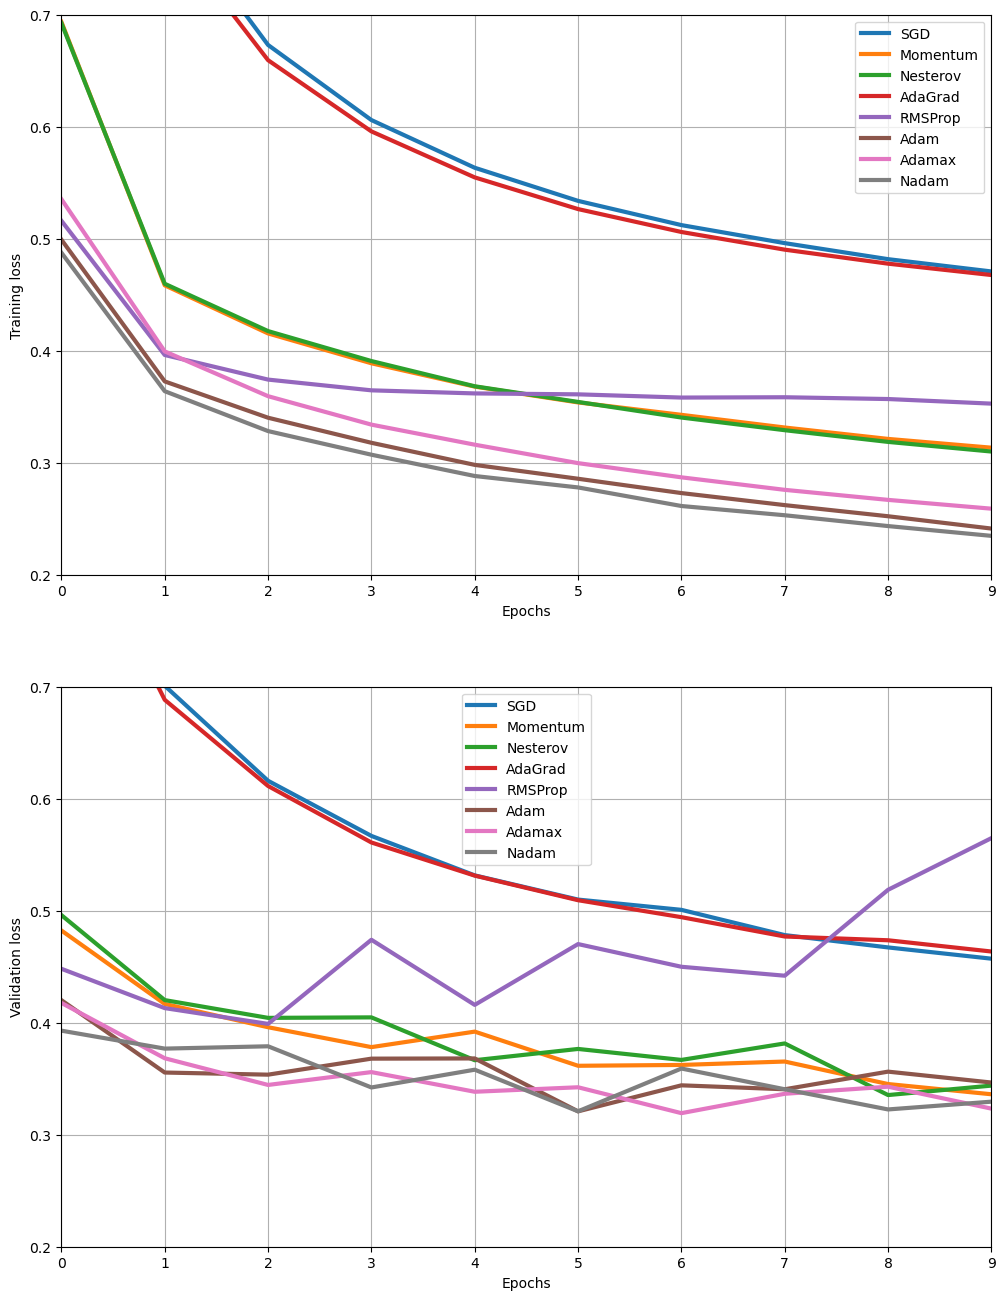

In [80]:
# 2. visualize the learning curves of all the optimizers
fig5, ax5 = plt.subplots(2,1, figsize=(12, 16))
for i, loss in enumerate(("loss", "val_loss")):  
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam),
                                 opt_names.split()):
        ax5[i].plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    ax5[i].grid()
    ax5[i].set_xlabel("Epochs")
    ax5[i].set_ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    ax5[i].legend(loc="best")
    ax5[i].axis([0, 9, 0.2, 0.7])